In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm
import os

from utils.models import mdn
from utils.models.vae import VAE
from utils.models.rnn import RNN
from utils import utils, model_config

import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

from IPython.display import HTML, Image
import io
import base64

In [3]:
rc('animation', html='html5')

## Collect images for training from Youtube

In [4]:
all_frames = []

In [5]:
frames_1 = utils.get_frames_from_youtube_video("https://www.youtube.com/watch?v=i8dh9gDzmz8", utils.frame_preprocessor)
frames_2 = utils.get_frames_from_youtube_video("https://www.youtube.com/watch?v=SUXWAEX2jlg", utils.frame_preprocessor)

In [6]:
all_frames.extend(frames_1)
all_frames.extend(frames_2)
all_frames = np.array(all_frames)

In [7]:
all_frames.shape

(7200, 64, 64, 3)

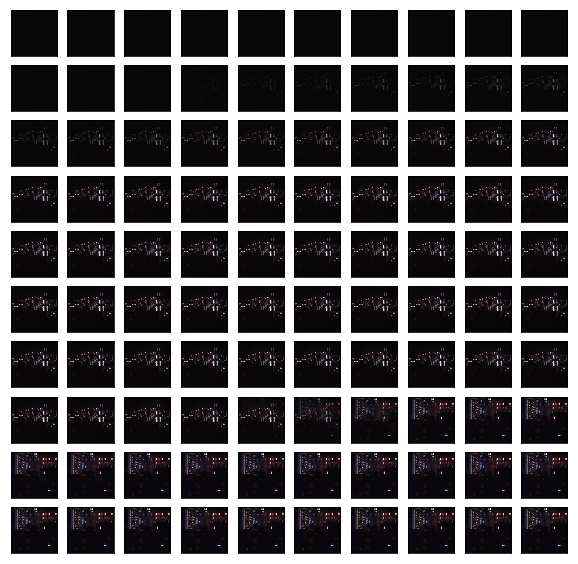

In [8]:
utils.show_image_grid(all_frames, n_images=100, n_rows=10, randomize=False)

## Train VAE

Input is (64, 64, 3) and output is 32 dim vector

In [9]:
vae = VAE.init_default()

In [10]:
vae.train(all_frames, 100)

Train on 5760 samples, validate on 1440 samples
Epoch 1/100
5760/5760 [==============================] - 13s 2ms/step - loss: 676.2496 - vae_r_loss: 661.2343 - vae_kl_loss: 15.0152 - val_loss: 323.4578 - val_vae_r_loss: 310.2681 - val_vae_kl_loss: 13.1897
Epoch 2/100
5760/5760 [==============================] - 6s 1ms/step - loss: 483.9484 - vae_r_loss: 462.2593 - vae_kl_loss: 21.6891 - val_loss: 265.1336 - val_vae_r_loss: 243.0176 - val_vae_kl_loss: 22.1160
Epoch 3/100
5760/5760 [==============================] - 6s 1ms/step - loss: 368.1151 - vae_r_loss: 341.0050 - vae_kl_loss: 27.1101 - val_loss: 266.3156 - val_vae_r_loss: 243.1532 - val_vae_kl_loss: 23.1624
Epoch 4/100
5760/5760 [==============================] - 6s 1ms/step - loss: 298.6633 - vae_r_loss: 269.3907 - vae_kl_loss: 29.2725 - val_loss: 297.9662 - val_vae_r_loss: 276.9969 - val_vae_kl_loss: 20.9693
Epoch 5/100
5760/5760 [==============================] - 6s 1ms/step - loss: 260.9459 - vae_r_loss: 230.8685 - vae_kl_loss:

In [11]:
encoded_images = vae.encoder.predict(all_frames)
decoded_images = (vae.decoder.predict(encoded_images) * 255).astype(np.uint8)

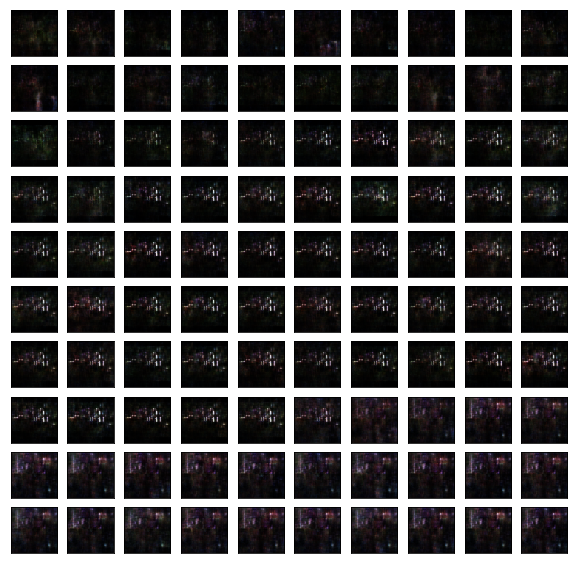

In [12]:
utils.show_image_grid(decoded_images, n_images=100, n_rows=10, randomize=False)

## Train RNN (GRU)

In [13]:
x_rnn_data, y_rnn_data = utils.create_rnn_data(encoded_images, model_config.GRU_TIME_STEPS)

In [14]:
x_rnn_data.shape

(7177, 24, 32)

In [15]:
y_rnn_data.shape

(7177, 32)

In [16]:
rnn = RNN.init_default()

In [17]:
rnn.train(x_rnn_data, y_rnn_data, 100)

Train on 5741 samples, validate on 1436 samples
Epoch 1/100
5741/5741 [==============================] - 27s 5ms/step - loss: 41.9698 - acc: 0.0010 - val_loss: 40.9222 - val_acc: 0.0000e+00
Epoch 2/100
5741/5741 [==============================] - 26s 4ms/step - loss: 36.0537 - acc: 0.0174 - val_loss: 40.1817 - val_acc: 0.0230
Epoch 3/100
5741/5741 [==============================] - 26s 5ms/step - loss: 32.5770 - acc: 0.0185 - val_loss: 39.3153 - val_acc: 0.0230
Epoch 4/100
5741/5741 [==============================] - 27s 5ms/step - loss: 30.3274 - acc: 0.0101 - val_loss: 39.1543 - val_acc: 0.0279
Epoch 5/100
5741/5741 [==============================] - 26s 5ms/step - loss: 28.6663 - acc: 0.0108 - val_loss: 38.2346 - val_acc: 0.0146
Epoch 6/100
5741/5741 [==============================] - 26s 5ms/step - loss: 27.4250 - acc: 0.0094 - val_loss: 38.1395 - val_acc: 0.0118
Epoch 7/100
5741/5741 [==============================] - 27s 5ms/step - loss: 26.4456 - acc: 0.0075 - val_loss: 38.0618 

## Generate new images

In [18]:
n_images_to_generate = 250
start_from_index = 1000
starter_frames = all_frames[start_from_index:start_from_index+model_config.GRU_TIME_STEPS]
generated_encoded_frames = vae.encoder.predict(starter_frames)

for i in range(n_images_to_generate):
    next_frames = rnn.model.predict(np.expand_dims(generated_encoded_frames[i:i + model_config.GRU_TIME_STEPS], axis=0))
    next_frame = np.apply_along_axis(mdn.sample_from_output, 1, next_frames, model_config.VAE_Z_DIM, model_config.NUMBER_MIXTURES,temp=1.0)
    next_frame = next_frame[0][0]
    generated_encoded_frames = np.vstack((generated_encoded_frames, next_frame))

In [19]:
generated_encoded_frames = generated_encoded_frames[model_config.GRU_TIME_STEPS:, :]

In [20]:
generated_decoded_frames = vae.decoder.predict(generated_encoded_frames)
generated_decoded_frames = (generated_decoded_frames * 255).astype(np.uint8)

In [21]:
generated_decoded_frames.shape

(250, 64, 64, 3)

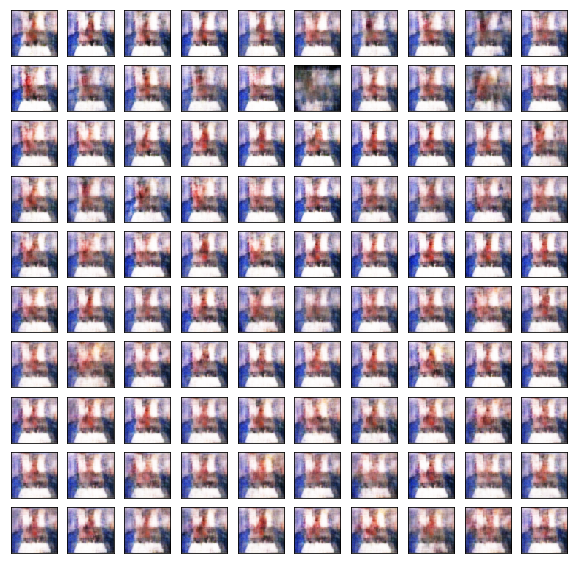

In [22]:
utils.show_image_grid(generated_decoded_frames, n_images=100, n_rows=10, randomize=False)

## Results

In [23]:
# This is used because the GIF file can take a lot of space,
# so we only want to save a sub-sequence
from_index = 2500
to_index = 3000

fig = plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])
img1 = ax1.imshow(all_frames[0])

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("VAE Encoded then Decoded")
ax2.set_xticks([])
ax2.set_yticks([])
img2 = ax2.imshow(decoded_images[0])
plt.close()

def animate(index_of_frame):
    if index_of_frame % 200 == 0 and index_of_frame != 0:
        print("Done with {0} frames".format(index_of_frame))
    img1.set_data(all_frames[from_index:to_index][index_of_frame])
    img2.set_data(decoded_images[from_index:to_index][index_of_frame])
    return (img1, img2,)

anim = animation.FuncAnimation(fig, animate, frames=(to_index-from_index-1), interval=41, blit=True)

animation_file_path = "./art/vae_decoded_vs_original.gif"
if os.name == 'nt':
    animation_file_path = "./art/vae_decoded_vs_original.mp4"

anim.save(animation_file_path, writer='imagemagick', fps=24)

c:\users\vecse\anaconda3\envs\kaggle\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


Done with 200 frames
Done with 400 frames


In [30]:
if os.name == 'nt':
    video = io.open(animation_file_path, 'r+b').read()
    encoded = base64.b64encode(video)
    HTML(data='''
                <video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>
              '''.format(encoded.decode('ascii')))
else:
    Image(url=animation_file_path)

In [25]:
fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title("Generated with VAE and RNN")
ax1.set_xticks([])
ax1.set_yticks([])
img1 = ax1.imshow(generated_decoded_frames[0])
plt.close()

def animate(index_of_frame):
    if index_of_frame % 200 == 0 and index_of_frame != 0:
        print("Done with {0} frames".format(index_of_frame))
    img1.set_data(generated_decoded_frames[index_of_frame])
    return (img1,)

anim = animation.FuncAnimation(fig, animate, frames=len(generated_decoded_frames), interval=41, blit=True)

generated_animation_file_path = "./art/generated_image_sequence.gif"
if os.name == 'nt':
    generated_animation_file_path = "./art/generated_image_sequence.mp4"
    
anim.save(generated_animation_file_path, writer='imagemagick', fps=24)

c:\users\vecse\anaconda3\envs\kaggle\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


Done with 200 frames


In [29]:
if os.name == 'nt':
    video = io.open(generated_animation_file_path, 'r+b').read()
    encoded = base64.b64encode(video)
    HTML(data='''
                <video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>
              '''.format(encoded.decode('ascii')))
else:
    Image(url=generated_animation_file_path)